<a href="https://colab.research.google.com/github/MockaWolke/SVI_Model_ToolBox/blob/master/ND_Traininng_own_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/MockaWolke/SVI_Model_ToolBox.git
from google.colab import drive
drive.mount('/content/drive')
!cp drive/MyDrive/UAL/ND_Data.zip ND_Data.zip 
!unzip -q ND_Data.zip -d SVI_Model_ToolBox
!rm  ND_Data.zip
!mkdir SVI_Model_ToolBox/model_info
!mkdir SVI_Model_ToolBox/model_info/logs
!mkdir SVI_Model_ToolBox/model_info/weights
!mkdir SVI_Model_ToolBox/model_info/models

import tensorflow as tf
import pandas as pd
import numpy as np
import tensorflow_datasets as tfds
import os
os.chdir("SVI_Model_ToolBox")
import ds_generator
import models
import plotting

Cloning into 'SVI_Model_ToolBox'...
remote: Enumerating objects: 110, done.
remote: Total 110 (delta 0), reused 0 (delta 0), pack-reused 110
Receiving objects: 100% (110/110), 94.16 MiB | 13.91 MiB/s, done.
Resolving deltas: 100% (20/20), done.
Checking out files: 100% (80/80), done.
Mounted at /content/drive


In [ ]:
df = pd.read_csv("ND_Data/data.csv",index_col = 0)
train_df = df.loc[df["ds_type"]=="train"]
val_df = df.loc[df["ds_type"]=="val"]

In [ ]:
df.head()

,key,easting,northing,view_direction,sequence_key,Path,City,night_name,ds_type
0,08X75PE9Ij8oqD9SH2GJZw,415481.066516,6.188003e+06,Forward,qqbnlmi5l2fv5z7ktpxqa0,Places_Data/train_val/moscow/database,moscow,Night,train
1,sf9VFjm2v6Apae8ASW3MTA,330192.964011,-4.197296e+06,Forward,ppvzgiujnoc1eoeyi2j1zk,Places_Data/train_val/melbourne/query,melbourne,Day,train
2,CrIzVu-uN3Ri8R30Exjo_g,623775.788294,5.804146e+06,Forward,E7PW3VQOLaw2vS44WjULkw,Places_Data/train_val/amsterdam/database,amsterdam,Day,train
3,tWUUxtJHfAvnGkD4wGzn2Q,411252.605886,3.716269e+06,Forward,ZWzBdDt6Rqu3obfFvHOdEA,Places_Data/train_val/phoenix/database,phoenix,Day,train
4,rJ91PhdsaVVVYSUDWpiQhg,382706.691773,6.671440e+06,Forward,qVzgSOt-Be6mKEy_zVAomw,Places_Data/train_val/helsinki/database,helsinki,Day,train


In [ ]:
"""
Generate tf Datasets for training
"""

import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

label_dict = {"Night":1, "Day":0}
batch_size = 64

def mapping(path,label):

    image = tf.io.read_file(path)
    image = tf.cast(tf.io.decode_jpeg(image, channels=3),tf.float32)
    label = tf.one_hot(label,2)
    return image, label



def get_ds(df, kind = "train"): 

    path = f"ND_Data/{kind}/"
    imgs = df["key"] + ".jpg"

    #assert all([img in os.listdir(path) for img in imgs]), "Immage not found"

    image_paths = path + imgs

    labels = df["night_name"].map(label_dict)

    ds = tf.data.Dataset.from_tensor_slices((image_paths,labels))

    ds = ds.map(mapping)
    ds = ds.batch(batch_size=batch_size, drop_remainder=True)
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds


def get_train_and_val():

    train_ds = get_ds(train_df,kind="train")
    val_ds = get_ds(val_df,kind="val")

    return train_ds,val_ds


train_ds, val_ds = get_train_and_val()

In [ ]:
import tensorflow.keras.layers as layers

# some img_augmentation
img_augmentation = tf.keras.models.Sequential(
    [
        tf.keras.layers.RandomRotation(factor=0.15),
        tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        tf.keras.layers.RandomFlip(mode="horizontal"),
        tf.keras.layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

def transfer_model(number_classes,loss,architecture = tf.keras.applications.efficientnet.EfficientNetB2,name=None):

    inputs = tf.keras.Input([260,260,3])
    x = tf.keras.layers.Resizing(224,224)(inputs)

    x = img_augmentation(x) # apply image augmentaion

    print(x.shape)

    model = architecture(
        include_top=False,
        weights='imagenet',
        input_tensor= x)

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.45
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(number_classes, activation="softmax", name="pred",kernel_regularizer=tf.keras.regularizers.L2())(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name=name)

    return model


inputs = tf.keras.Input([260,260,3])

x = img_augmentation(inputs)

x = layers.Conv2D(32,9,strides=4) (x)
x = layers.BatchNormalization()(x)
x = layers.ReLU() (x)
x = layers.MaxPool2D(2) (x)
x = layers.Conv2D(64,7,strides=3) (x)
x = layers.BatchNormalization()(x)
x = layers.ReLU() (x)
x = layers.MaxPool2D(2) (x)

x = layers.Conv2D(64,3,strides=2)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU() (x)
x = layers.GlobalMaxPooling2D(name="avg_pool")(x)
x = layers.Dropout(0.15, name="top_dropout")(x)
outputs = layers.Dense(2, activation="softmax", name="pred",kernel_regularizer=tf.keras.regularizers.L2())(x)
model = tf.keras.Model(inputs, outputs, name="try_drop")

In [ ]:

model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),loss=tf.keras.losses.BinaryCrossentropy(),metrics=["accuracy"])

In [ ]:
log_dir = f"model_info/logs/" + model.name 
checkpoint_path = f"model_info/weights/{model.name}/"
last_model = f"model_info/models/{model.name}"

# os.makedirs(log_dir)
# os.makedirs(checkpoint_path)
# os.makedirs(last_model)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path+ "weights",
    verbose=1,
    monitor='val_accuracy',
    save_weights_only=True,
    save_best_only=True)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.02,
    patience=8,
    verbose=1,
    mode='auto',
    restore_best_weights=True
) 

In [ ]:
hist = model.fit(train_ds, epochs=10, validation_data=val_ds,callbacks=[tensorboard_callback,cp_callback,early_stopping_callback])

Epoch 1/10
347/347 [==============================] - ETA: 0s - loss: 0.2220 - accuracy: 0.9742
Epoch 1: val_accuracy improved from -inf to 0.94271, saving model to model_info/weights/try_drop/weights
347/347 [==============================] - 37s 64ms/step - loss: 0.2220 - accuracy: 0.9742 - val_loss: 0.2173 - val_accuracy: 0.9427
Epoch 2/10
347/347 [==============================] - ETA: 0s - loss: 0.1406 - accuracy: 0.9858
Epoch 2: val_accuracy improved from 0.94271 to 0.95685, saving model to model_info/weights/try_drop/weights
347/347 [==============================] - 22s 63ms/step - loss: 0.1406 - accuracy: 0.9858 - val_loss: 0.1891 - val_accuracy: 0.9568
Epoch 3/10
347/347 [==============================] - ETA: 0s - loss: 0.1185 - accuracy: 0.9859
Epoch 3: val_accuracy did not improve from 0.95685
347/347 [==============================] - 26s 74ms/step - loss: 0.1185 - accuracy: 0.9859 - val_loss: 0.1917 - val_accuracy: 0.9479
Epoch 4/10
346/347 [============================>

In [ ]:
model._name = "try_drop_fur"
log_dir = f"model_info/logs/" + model.name 
checkpoint_path = f"model_info/weights/{model.name}/"
last_model = f"model_info/models/{model.name}"

# os.makedirs(log_dir)
# os.makedirs(checkpoint_path)
# os.makedirs(last_model)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path+ "weights",
    verbose=1,
    monitor='val_accuracy',
    save_weights_only=True,
    save_best_only=True)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.02,
    patience=8,
    verbose=1,
    mode='auto',
    restore_best_weights=True
) 

In [ ]:
hist2 = model.fit(train_ds, epochs=20, validation_data=val_ds,callbacks=[tensorboard_callback,cp_callback,early_stopping_callback],initial_epoch=10)

Epoch 11/20
347/347 [==============================] - ETA: 0s - loss: 0.0707 - accuracy: 0.9892
Epoch 11: val_accuracy improved from -inf to 0.97197, saving model to model_info/weights/try_drop_fur/weights
347/347 [==============================] - 36s 104ms/step - loss: 0.0707 - accuracy: 0.9892 - val_loss: 0.1371 - val_accuracy: 0.9720
Epoch 12/20
347/347 [==============================] - ETA: 0s - loss: 0.0666 - accuracy: 0.9897
Epoch 12: val_accuracy did not improve from 0.97197
347/347 [==============================] - 22s 64ms/step - loss: 0.0666 - accuracy: 0.9897 - val_loss: 0.1347 - val_accuracy: 0.9668
Epoch 13/20
347/347 [==============================] - ETA: 0s - loss: 0.0638 - accuracy: 0.9907
Epoch 13: val_accuracy did not improve from 0.97197
347/347 [==============================] - 22s 63ms/step - loss: 0.0638 - accuracy: 0.9907 - val_loss: 0.1345 - val_accuracy: 0.9688
Epoch 14/20
347/347 [==============================] - ETA: 0s - loss: 0.0620 - accuracy: 0.990

In [ ]:
test_df = df.loc[df["ds_type"]=="test"]
test_ds = get_ds(test_df,kind="test")

In [ ]:
ls model_info/weights/try_drop_fur/

checkpoint  weights.data-00000-of-00001  weights.index


In [ ]:
model.load_weights("model_info/weights/try_drop_fur/weights")

In [ ]:
model.evaluate(test_ds)

38/38 [==============================] - 3s 74ms/step - loss: 0.2811 - accuracy: 0.9174


[0.2811254560947418, 0.9173519611358643]

In [ ]:
preds 
preds = np.argmax(preds,axis=1)

In [ ]:
preds

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
labels = list(test_ds.map(lambda x,y:y))
labels = np.concatenate([i.numpy() for i in labels])
labels = np.argmax(labels,axis=1)
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
np.mean(preds==labels)

0.9173519736842105

In [ ]:
wrong_images

array([  10,   20,   56,   60,   77,   99,  102,  122,  141,  147,  153,
        200,  203,  207,  220,  221,  223,  225,  231,  235,  267,  283,
        285,  295,  315,  319,  321,  330,  332,  334,  345,  346,  372,
        374,  376,  379,  384,  412,  421,  422,  449,  466,  471,  475,
        476,  481,  522,  526,  527,  536,  543,  556,  558,  579,  582,
        585,  603,  605,  621,  629,  630,  642,  643,  645,  650,  658,
        680,  683,  689,  698,  710,  716,  726,  739,  743,  746,  749,
        768,  796,  809,  814,  816,  817,  818,  847,  851,  874,  896,
        909,  919,  928,  934,  942,  944,  947,  951,  954,  967,  969,
        970,  971,  976,  977,  986, 1006, 1007, 1012, 1020, 1024, 1025,
       1026, 1034, 1036, 1044, 1052, 1054, 1073, 1083, 1087, 1091, 1096,
       1104, 1105, 1112, 1118, 1121, 1132, 1137, 1139, 1154, 1168, 1173,
       1175, 1186, 1190, 1210, 1211, 1214, 1244, 1248, 1255, 1267, 1278,
       1290, 1303, 1307, 1338, 1370, 1371, 1379, 13

In [ ]:
wrong_images = np.argwhere((preds==labels)==0).reshape(-1)
len(wrong_images)

201

In [ ]:
imgs = test_df.iloc[wrong_images]

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
imgs.iloc[0]["key"]

'xBdVDqrxiob17bPp1WwHQc'

In [ ]:
import tqdm

100%|██████████| 201/201 [04:23<00:00,  1.31s/it]


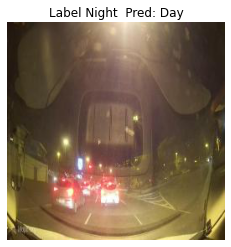

In [ ]:
dic = {0:"Day",1:"Night"}

def get_ds(i): 

    key = imgs.iloc[i]["key"] 

    path = f"ND_Data/test/"+ key + ".jpg"
    plt.imshow(plt.imread(path))
    plt.axis('off')

    label = dic[labels[wrong_images[i]]]
    pred = dic[preds[wrong_images[i]]]

    plt.title(f"Label {label}  Pred: {pred}")
    plt.savefig(f"wrong_labels/{key}.jpg")


for i in tqdm.tqdm(range(len(imgs))):

  get_ds(i)


In [ ]:
mkdir results_day_night

In [ ]:
imgs = test_df.iloc[wrong_images]
len(imgs)

201

In [ ]:
df = test_df.iloc[:38*64].copy()
df["pred"]=preds
df["labels"]=labels

In [ ]:
df

,key,easting,northing,view_direction,sequence_key,Path,City,night_name,ds_type,pred,labels
26273,uqEgrwPayhEZ-sLiUKzyIA,315472.793342,7.386815e+06,Forward,hUH_PDbyQMyeuu-OETfBwg,Places_Data/train_val/saopaulo/database,saopaulo,Day,test,0,0
26274,ZWpCCy1vrGV5GBnzkExhor,326427.216377,7.397452e+06,Forward,45c3olap4kgv6jy4oal8bs,Places_Data/train_val/saopaulo/query,saopaulo,Day,test,0,0
26275,RMRJQKjP4lAAriX8j_KqIA,328479.187109,7.398110e+06,Forward,mifAHnwLS_CYcu1Tn52Ouw,Places_Data/train_val/saopaulo/database,saopaulo,Day,test,0,0
26276,ldmBLAJv-ooSGhy5Xy-1_Q,332249.379896,7.396232e+06,Forward,ti93sIGeQoOBGHfnKUJXRA,Places_Data/train_val/saopaulo/database,saopaulo,Day,test,0,0
26277,OqCy8ula241IcqRc_lAaAg,319398.355208,7.390784e+06,Forward,vmrk929p4r4a59hb99hqnl,Places_Data/train_val/saopaulo/database,saopaulo,Day,test,0,0
...,...,...,...,...,...,...,...,...,...,...,...
28700,2IxYESOQjlOV8OJi8c872L,337478.240353,7.390546e+06,Forward,l8rg583c6djphmy4ta1m4s,Places_Data/train_val/saopaulo/database,saopaulo,Night,test,1,1
28701,osenWUEyfj_K669jKbpo4F,337474.362106,7.390545e+06,Forward,l8rg583c6djphmy4ta1m4s,Places_Data/train_val/saopaulo/database,saopaulo,Night,test,1,1
28702,ga-cnrWkIw2EfUjKpcVNLe,337470.483982,7.390544e+06,Forward,l8rg583c6djphmy4ta1m4s,Places_Data/train_val/saopaulo/database,saopaulo,Night,test,1,1
28703,LCPu0ppVDSH_tJcnAahMrm,337468.539817,7.390543e+06,Forward,l8rg583c6djphmy4ta1m4s,Places_Data/train_val/saopaulo/database,saopaulo,Night,test,1,1


In [ ]:
certainty = model.predict(test_ds)

In [ ]:
df["certainty_day"]=certainty[:,0]
df["certainty_night"]=certainty[:,1]

In [ ]:
!du -sh  wrong_labels/

4.5M	wrong_labels/


In [ ]:
cp  -r results_day_night ../drive/MyDrive/UAL/results_day_night

In [ ]:
ls ../drive/MyDrive/UAL/

model_info/  ND_Traininng_MN_V2.ipynb    Transfer.ipynb
models/      ND_Traininng_MN_V3.ipynb    Transfer_train_all_further.ipynb
ND_Data.zip  ND_Traininng_own_cnn.ipynb  Transfer_train_all.ipynb


In [ ]:
cp -r model_info/logs results_day_night/logs

In [ ]:
ls model_info

logs/  models/  weights/


In [ ]:
model.save("results_day_night/final_model/day_night_final")

INFO:tensorflow:Assets written to: results_day_night/final_model/day_night_final/assets


INFO:tensorflow:Assets written to: results_day_night/final_model/day_night_final/assets


In [ ]:
!mkdir results_day_night/final_model

In [ ]:
ls  results_day_night/wrong_labels/

0NJCSpNpl9UesiFKrQDOlA.jpg  l5hFhup2z1dBCL39vljpFK.jpg
0oIU9Tq1X9pWWf9q9Whvtk.jpg  LHRd04a-CoDJi8JSjS8MYm.jpg
0yEjhZqCngnrXMbFLePc9h.jpg  lJJVV1aI3Zf-Qf6m0kbT_6.jpg
16l8p3mPa7_pVGL5KbQIgw.jpg  Lmk23DQiyawjgk6QUo7orM.jpg
1OrAVYGoAYCUAeF24TslZz.jpg  LR6ifO3agDCjKPArg8K3Vl.jpg
1QLM6F5c95cmb9gxqvzF4G.jpg  LsgX4klxapKioeyCLtZYi5.jpg
1-vty23VpdC0q4cUEZm6E4.jpg  LTuz1rAKn7XZyXne4serTl.jpg
2b0LI1PaN4AM0xyQiYQUAS.jpg  m8U4041qAiRENFgciwyn1s.jpg
2d1Yt-Pem8OsGiG5nDTPGG.jpg  miWVvW1Aj3dnoIfe0G_OPM.jpg
36I9Mjaj2B88m3H6OmVlVu.jpg  MuYj2OSp4OfL7TQO6kUvin.jpg
3n-8blE4I2xwAxyNJVmpZi.jpg  MwF9Wj8glJ2YADzLw4GfRd.jpg
3wemzhbQd7J0VMMFbJGOIi.jpg  N0b5qtKf8J0yr6RcDBrYew.jpg
4ELgJYxi1_iUbyKte_ny2-.jpg  NJBI5sptqijm7wLZRMN301.jpg
5D-4a1tw8xMwje-pebw2z8.jpg  NnBY8fKEV0lbW5E2xC6Al-.jpg
7c0PJUQBrVWCgTPV3FWpBd.jpg  o1G2StaVyDLt0AFJskda49.jpg
-7J3phmKKPmuGhBQtVvLr9.jpg  o31onszHgTxnK7GolI8RRw.jpg
7jcGvWmeRyZrONNJOIS21j.jpg  O3e4Ghb87pUwNN9jT1T32J.jpg
89ISUjPwBrmjISAmaQmrd9.jpg  O5LETYcFd8qd5DVMkI7nxe.jpg
8GgbxAhYf0

In [ ]:
mv  wrong_labels results_day_night/wrong_labels

In [ ]:
df.to_csv("results_day_night/results_day_night.csv")

In [ ]:
%load_ext tensorboard
%tensorboard --logdir model_info/logs

In [ ]:
model = models.unfreeze_model(model,n_layers = 5)
model._name = "MNV3_A"
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),loss=tf.keras.losses.BinaryCrossentropy(),metrics=["accuracy"])

In [ ]:
log_dir = f"model_info/logs/" + model.name 
checkpoint_path = f"model_info/weights/{model.name}/"
last_model = f"model_info/models/{model.name}"

os.makedirs(log_dir)
os.makedirs(checkpoint_path)
os.makedirs(last_model)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path+ "weights",
    verbose=1,
    monitor='val_accuracy',
    save_weights_only=True,
    save_best_only=True)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.02,
    patience=4,
    verbose=1,
    mode='auto',
    restore_best_weights=True
) 

In [ ]:
hist_a = model.fit(train_ds, epochs=15, validation_data=val_ds,callbacks=[tensorboard_callback,cp_callback,early_stopping_callback],initial_epoch = 5)

In [ ]:
import matplotlib.pyplot as plt
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
acc += hist_a.history['accuracy']
val_acc += hist_a.history['val_accuracy']

loss += hist_a.history['loss']
val_loss += hist_a.history['val_loss']

initial_epochs = 5

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
!cp -r model_info/logs/try ../drive/MyDrive/UAL/model_info/logs/try
!cp -r model_info/weights/* ../drive/MyDrive/UAL/model_info/weights/*


In [ ]:
ls model_info 